## Load Data

In [56]:
import pandas as pd

train = pd.read_csv('data/Train.csv')
test = pd.read_csv('data/Test.csv')

## Preprocessing Data

In [57]:
#define the preprocessing function
def preprocess(df):
    #fill missing values
    df['Alcohol Consumption'] = df['Alcohol Consumption'].fillna('Never')
    df['Family History'] = df['Family History'].fillna('None')
    df['Chronic Diseases'] = df['Chronic Diseases'].fillna('None')
    df['Medication Use'] = df['Medication Use'].fillna('None')
    df['Education Level'] = df['Education Level'].fillna('None')
    
    #replace the blood pressure column with two separate columns
    df[['Systolic', 'Diastolic']] = df['Blood Pressure (s/d)'].str.split('/', expand=True)
    df['Systolic'] = pd.to_numeric(df['Systolic'])
    df['Diastolic'] = pd.to_numeric(df['Diastolic'])
    df = df.drop(columns=['Blood Pressure (s/d)'])
    
    return df

In [58]:
# apply preprocessing to datasets
train = preprocess(train)
test = preprocess(test)

In [59]:
#encode label columns
from sklearn.preprocessing import LabelEncoder

label_columns = ["Gender", "Physical Activity Level", "Smoking Status",
                 "Alcohol Consumption", "Diet", "Medication Use",
                 "Family History", "Chronic Diseases", "Mental Health Status",
                 "Sleep Patterns", "Education Level", "Income Level"]
le = LabelEncoder()
for column in label_columns:
    train[column] = le.fit_transform(train[column])
    test[column] = le.fit_transform(test[column])

In [60]:
#find the main correlators of age
train.corr()['Age (years)']

Gender                         0.021714
Height (cm)                    0.020322
Weight (kg)                    0.002521
Cholesterol Level (mg/dL)      0.432368
BMI                           -0.008042
Blood Glucose Level (mg/dL)    0.428573
Bone Density (g/cm²)          -0.937712
Vision Sharpness              -0.899692
Hearing Ability (dB)           0.712374
Physical Activity Level       -0.000136
Smoking Status                -0.176622
Alcohol Consumption            0.039399
Diet                           0.005510
Chronic Diseases               0.011892
Medication Use                 0.018743
Family History                -0.019260
Cognitive Function            -0.508058
Mental Health Status           0.011106
Sleep Patterns                 0.007218
Stress Levels                  0.029093
Pollution Exposure            -0.010464
Sun Exposure                   0.009245
Education Level                0.006956
Income Level                  -0.020475
Age (years)                    1.000000


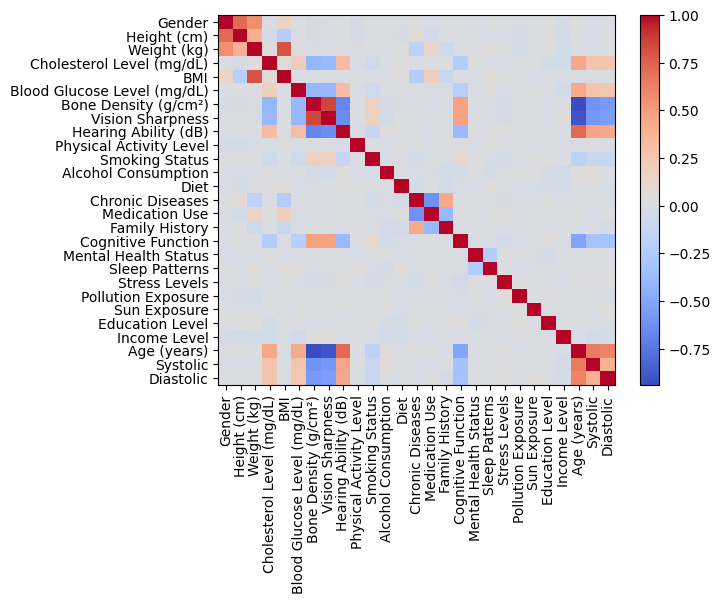

In [61]:
#visualization of correlators
import matplotlib.pyplot as plt

im = plt.imshow(train.corr(), cmap='coolwarm', aspect='auto')
plt.xticks(range(len(train.corr().columns)), train.corr().columns, rotation=90)
plt.yticks(range(len(train.corr().index)), train.corr().index)
cbar = plt.colorbar(im)

In [96]:
from sklearn.model_selection import train_test_split

train_x = train.drop(columns=['Age (years)'])
train_y = train['Age (years)']

## Prediction

#### Lasso

In [63]:
from sklearn import linear_model

reg_lasso = linear_model.Lasso(alpha=0.1)
reg_lasso.fit(train_x, train_y)
reg_lasso.predict(test)

array([86.83091031, 70.24711067, 73.38045778, ..., 77.23481648,
       31.74317617, 60.76599235])

#### Ridge

In [64]:
reg_ridge = linear_model.Ridge(alpha=.5)
reg_ridge.fit(train_x, train_y)
reg_ridge.predict(test)

array([87.20868637, 70.88636015, 74.68774645, ..., 78.10433682,
       32.38084978, 59.17016223])

#### ElasticNet

In [67]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression

reg_en = ElasticNet(random_state=0)
reg_en.fit(train_x, train_y)
reg_en.predict(test)

array([80.82765415, 68.04864462, 67.04140142, ..., 67.72095768,
       35.15668494, 67.08218452])

#### GradientBoostingRegressor

In [88]:
from sklearn.ensemble import GradientBoostingRegressor

reg_gb = GradientBoostingRegressor(random_state=0)
reg_gb.fit(train_x, train_y)
reg_gb.predict(test)

array([86.69659199, 71.90515457, 74.80247644, ..., 80.92785237,
       33.19174845, 60.58684695])

#### Random Forest

In [69]:
from sklearn.ensemble import RandomForestRegressor

reg_rf = RandomForestRegressor(n_estimators=100, random_state=42)
reg_rf.fit(train_x, train_y)
reg_rf.predict(test)

array([88.25, 73.8 , 72.54, ..., 83.13, 32.05, 62.67])

## Evaluation

#### R2 Score

In [89]:
from sklearn.metrics import r2_score

print(r2_score(train_y, reg_lasso.predict(test)))
print(r2_score(train_y, reg_ridge.predict(test)))
print(r2_score(train_y, reg_en.predict(test)))
print(r2_score(train_y, reg_gb.predict(test)))
print(r2_score(train_y, reg_rf.predict(test)))

0.935141279269218
0.9367444035432939
0.788909317702334
0.9528099383291232
0.9903493312801113


#### MSE

In [90]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(train_y, reg_lasso.predict(test)))
print(mean_squared_error(train_y, reg_ridge.predict(test)))
print(mean_squared_error(train_y, reg_en.predict(test)))
print(mean_squared_error(train_y, reg_gb.predict(test)))
print(mean_squared_error(train_y, reg_rf.predict(test)))

27.433366260929333
26.755290978577385
89.28526397827892
19.96003361007699
4.081954233333334


#### MAPE

In [91]:
from sklearn.metrics import mean_absolute_percentage_error

print(mean_absolute_percentage_error(train_y, reg_lasso.predict(test)))
print(mean_absolute_percentage_error(train_y, reg_ridge.predict(test)))
print(mean_absolute_percentage_error(train_y, reg_en.predict(test)))
print(mean_absolute_percentage_error(train_y, reg_gb.predict(test)))
print(mean_absolute_percentage_error(train_y, reg_rf.predict(test)))

0.09509262038545682
0.09359944553908837
0.17579091462643665
0.07920089218710953
0.035532360384513545


## Results

In [95]:
predictions = pd.DataFrame({'Real Age': train_y, 'Lasso': reg_lasso.predict(test), 'Ridge': reg_ridge.predict(test), 'ElasticNet': reg_en.predict(test), 'GradientBoostingRegressor': reg_gb.predict(test), 'RandomForestRegressor': reg_rf.predict(test)})
predictions.to_csv('predictions.csv', index=False)
predictions.head()

Real Age      Lasso      Ridge  ElasticNet  GradientBoostingRegressor  \
0        89  86.830910  87.208686   80.827654                  86.696592   
1        77  70.247111  70.886360   68.048645                  71.905155   
2        70  73.380458  74.687746   67.041401                  74.802476   
3        52  52.057328  51.375602   68.239084                  49.798676   
4        79  75.794845  75.025930   75.766995                  76.788224   

   RandomForestRegressor  
0                  88.25  
1                  73.80  
2                  72.54  
3                  50.05  
4                  78.68